In [53]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMAGE_SIZE = 256 #given 265*256
BATCH_SIZE = 32 #given 32(preferred)
CHANNELS = 3
EPOCHS = 10

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [5]:
class_names = dataset.class_names
class_names #the different plants healthy and diseased

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
645*32

20640

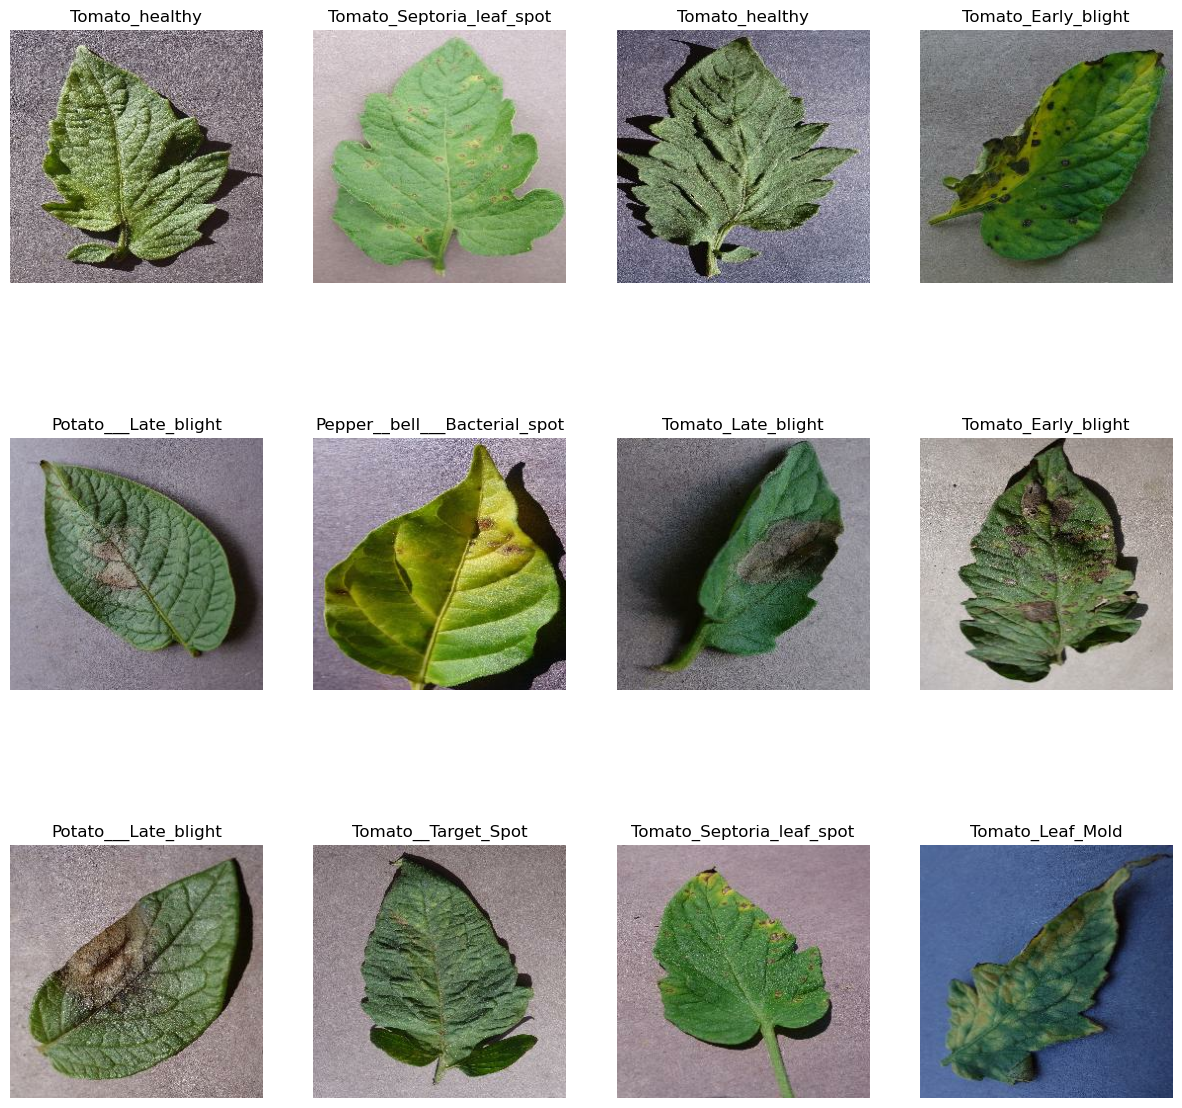

In [7]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        #print(image_batch[0].shape) # 256*256 pixels and rgb -> 3
        #print(label_batch.numpy)
   

In [8]:
len(dataset) #number of batches required to cover all the dataset images

645

80% --> training
20% --> 10% validation and 10% test

After training for 50 epochs -> validate -> another 50 ephocs and then test agin for better accuracy

In [9]:
training_size = 0.8
len(dataset)*training_size

516.0

In [10]:
training_dataset = dataset.take(516)
len(training_dataset)

516

In [11]:
testing_dataset = dataset.skip(516)
len(testing_dataset) 

129

In [12]:
validation_size = 0.1
len(dataset)*validation_size

64.5

In [13]:
validation_dataset = dataset.take(64)
len(validation_dataset)

64

In [14]:
testing_dataset = dataset.skip(64)
len(testing_dataset)

581

In [15]:
# Splitting the dataset into train,test and valiation
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split+test_split+val_split)==1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset) 

In [17]:
len(train_ds)

516

In [18]:
len(val_ds)

64

In [19]:
len(test_ds)

65

In [20]:
#Chaching the data prior to their training/testing/validation to run faster and to occupy memory efficiently

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
# resized and rescaled layers for training the models 

resize_and_rescale = tf.keras.Sequential([  
      layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
      layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
# augmented layers to acheive results on all types of images(rotated, flipped)

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
# train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=15
model = models.Sequential([
    resize_and_rescale,
    #data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"), 
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax"),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [27]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/10


516/516 [==============================] - 1446s 3s/step - loss: 1.6883 - accuracy: 0.4368 - val_loss: 0.9979 - val_accuracy: 0.6655
Epoch 2/10
516/516 [==============================] - 3128s 6s/step - loss: 0.8525 - accuracy: 0.7133 - val_loss: 0.5991 - val_accuracy: 0.8003
Epoch 3/10
516/516 [==============================] - 1062s 2s/step - loss: 0.5947 - accuracy: 0.7961 - val_loss: 0.4932 - val_accuracy: 0.8257
Epoch 4/10
516/516 [==============================] - 1053s 2s/step - loss: 0.4744 - accuracy: 0.8369 - val_loss: 0.3343 - val_accuracy: 0.8853
Epoch 5/10
516/516 [==============================] - 1075s 2s/step - loss: 0.3797 - accuracy: 0.8682 - val_loss: 0.3096 - val_accuracy: 0.8892
Epoch 6/10
516/516 [==============================] - 1097s 2s/step - loss: 0.3113 - accuracy: 0.8914 - val_loss: 0.2931 - val_accuracy: 0.8940
Epoch 7/10
516/516 [==============================] - 1083s 2s/step - loss: 0.2682 - accuracy: 0.9080 - val_loss: 0.6157 - val_accuracy: 0.7964
Epo

In [28]:
scores = model.evaluate(test_ds)

65/65 [==============================] - 178s 410ms/step - loss: 0.1723 - accuracy: 0.9399


In [29]:
scores

[0.17228515446186066, 0.9399038553237915]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 516}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

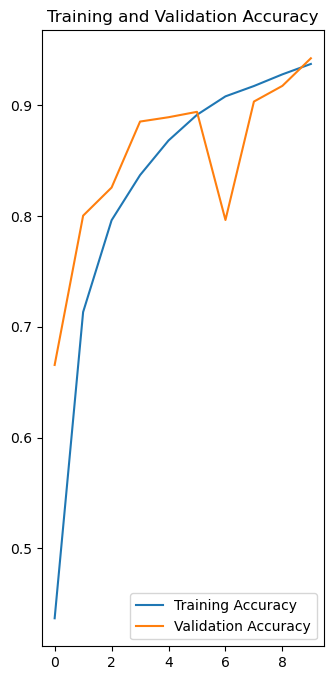

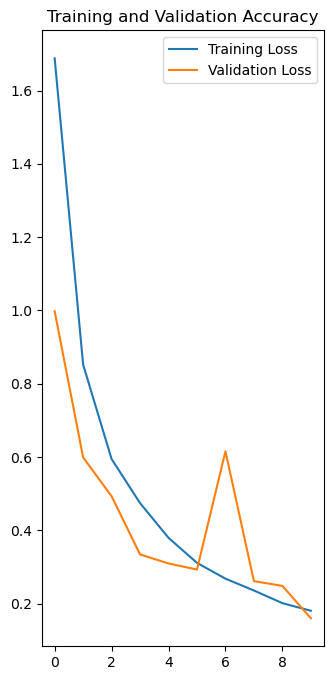

In [39]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Accuracy")

First image to predict
First image's actual label: Tomato_healthy
1/1 [==============================] - 0s 230ms/step
Predicted Label: Tomato_healthy


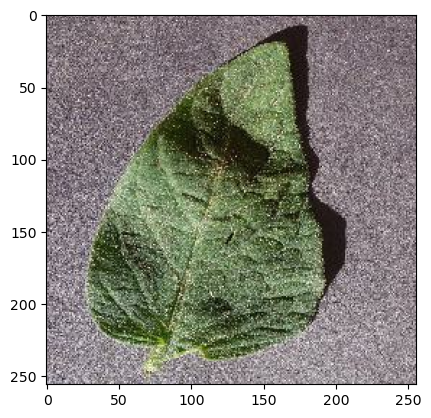

In [61]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("First image's actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [78]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence;




1/1 [==============================] - 0s 34ms/step


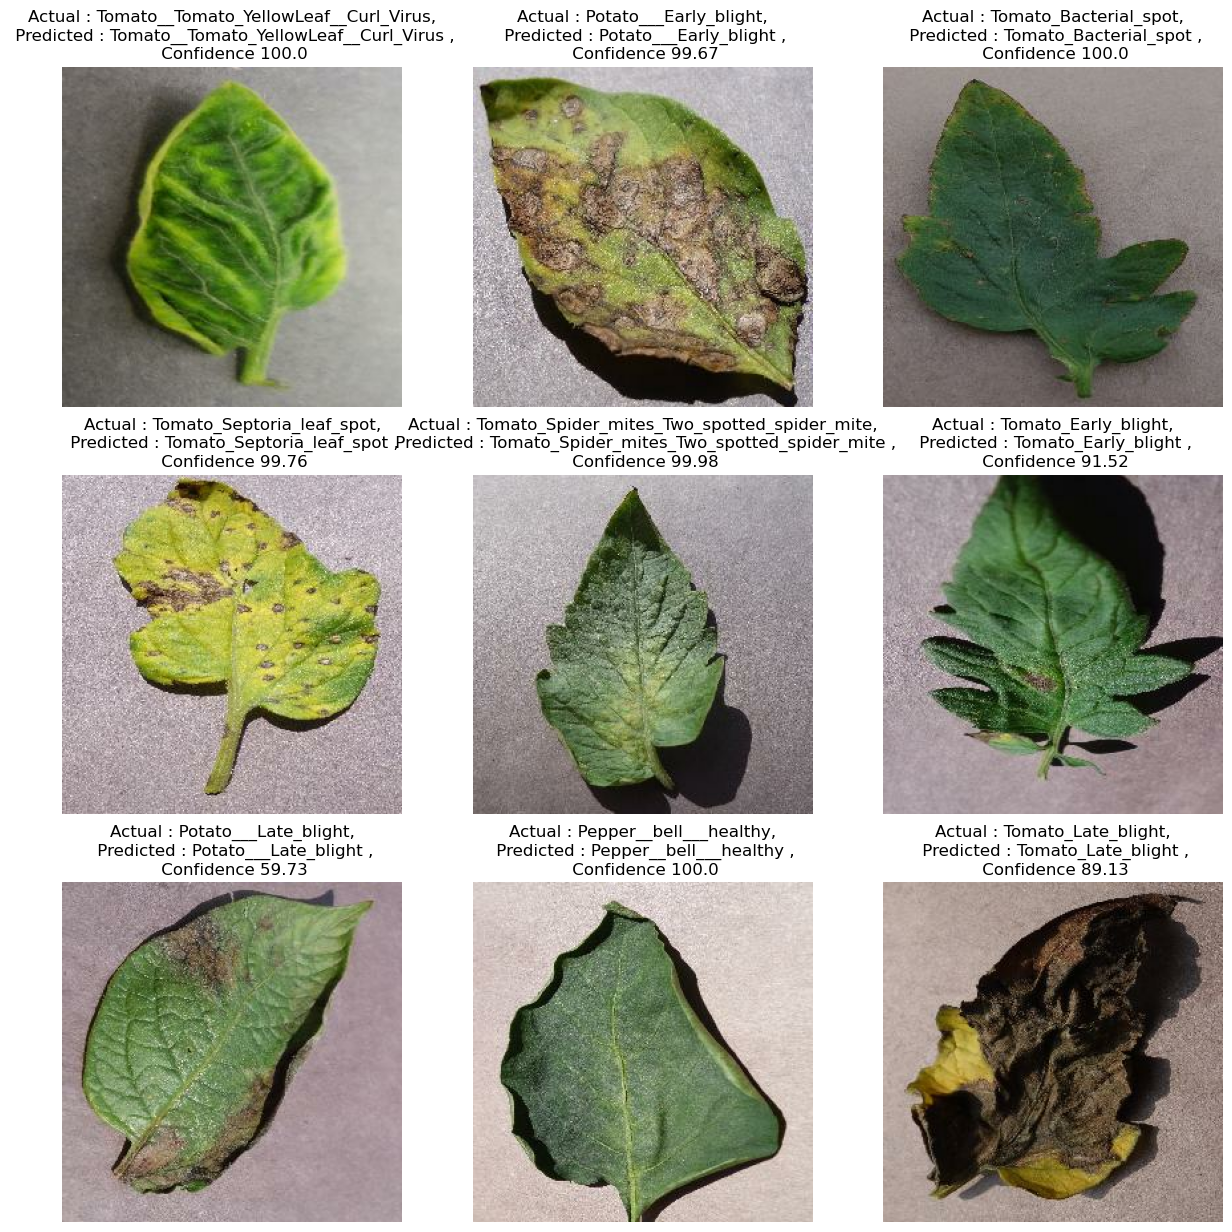

In [79]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual : {actual_class},\n Predicted : {predicted_class} ,\n Confidence {confidence}")
        plt.axis("off")

In [77]:
# import os
# model_version = max([int (i) for i in os.listdir("./models")+[0]])+1
# model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/3\assets


INFO:tensorflow:Assets written to: ./models/3\assets
